<a href="https://colab.research.google.com/github/Murcha1990/Raiffaizen_ML_summer2023/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_boosting/Raiff_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Различные реализации градиентного бустинга

Раньше для использования градиентного бустинга необходимо было самостоятельно имплементировать алгоритм. Этим занимались и в крупных корпорациях, которые использовали машинное обучение в своих задачах (например, Microsoft и Яндекс). Некоторые из этих модифицированных имплементаций вышли в open osurce и чаще всего именно они используются на практике. В настоящее время наиболее популярные следующие реализации:
* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

!["История"](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/seminars/sem15_boosting_part2/bst.png?raw=1)

## CatBoost

Ноутбук из официальной документации здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

## Симметричные деревья решений

Одной из отличительных особенностей CatBoost является то, что в качестве базовых моделей используются симметричные деревья (или oblivious trees).

Слева на рисунке изображено обычное дерево, справа - симметричное.

В симметричном дереве на каждом уровне проверяется одно и то же условие
(например, на втором уровне в обеих вершинах "вес > 65", на третьем уровне в каждой из четырех вершин будет проверяться какое-то одно условие и так далее).

Чем хороши симметричные деревья?

Симметричные деревья - это полные сбалансированные деревья с фиксированной структурой (мы заранее знаем, как будет выглядеть структура дерева выбранной глубины), поэтому они гораздо меньше склонны к переобучению, чем обычные деревья (ведь у обычного дерева при незначительном изменении обучающей выборки может полностью измениться его структура - то есть деревья серьезно подгоняются под данные; у симметричного дерева структура не изменится)
Симметричные деревья удобно хранить в памяти компьютера (в виде списка предикатов на каждом уровне), поэтому с ними эффективнее работать
Благодаря устойчивости симметричных деревьев к переобучению и независимости их структуры от обучающих данных CatBoost показывает отличные результаты даже с параметрами по умолчанию!



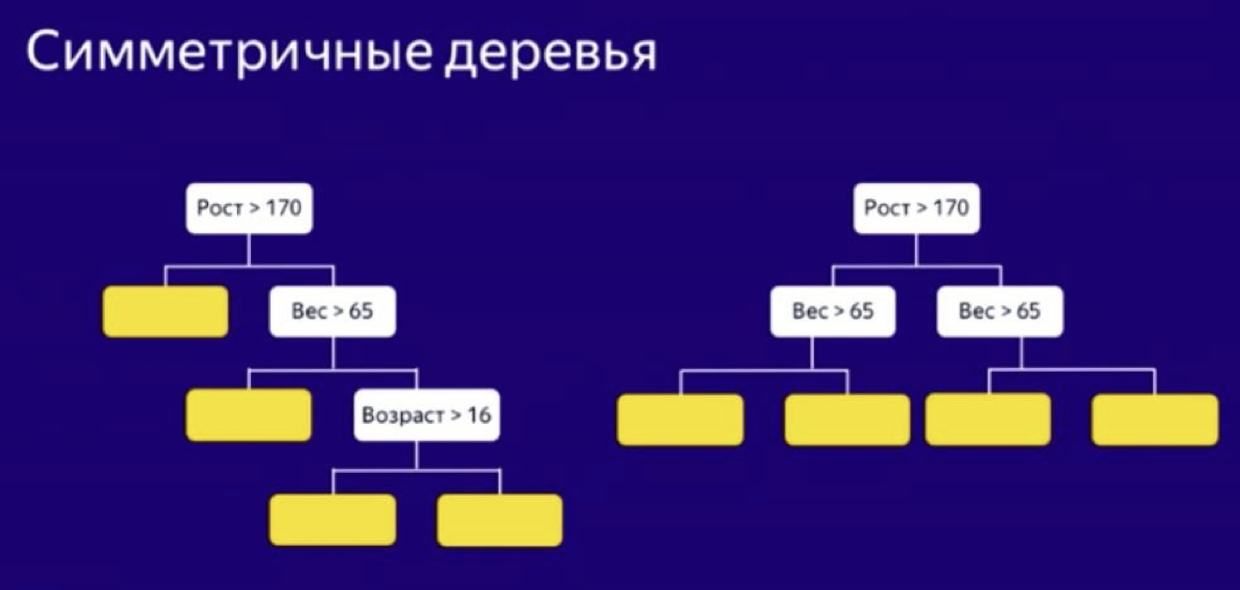

## Кодирование категориальных признаков в CatBoost

Существует несколько подходов к кодированию категориальных признаков. Основные - это

OneHot-encoding
Mean Target Encoding (счетчики), а у них много вариаций
Кроме основных подходов используются различные подходы, связанные с feature Engineering. Например, можно склеить два категориальных признака в одну колонку и вместо одной категории рассматривать пару значений категорий - и их уже кодировать. Такой подход будет учитывать взаимное влияние двух категориальных признаков и может показать хороший результат.

Для снижения переобучения при кодировании также добавляют шумы и случайные перестановки в данные.

Как видите, подходов к кодированию признаков очень много - и даже внутри выбранного способа кодировки есть вариации. Поэтому ручное кодирование признаков - это творческая и весьма непростая задача.

В CatBoost сочетается несколько подходов к кодированию категориальных признаков. Под капотом алгоритма одновременно обучаются несколько моделей - с разными кодировками, и выбирается кодировка, дающая наилучший результат.

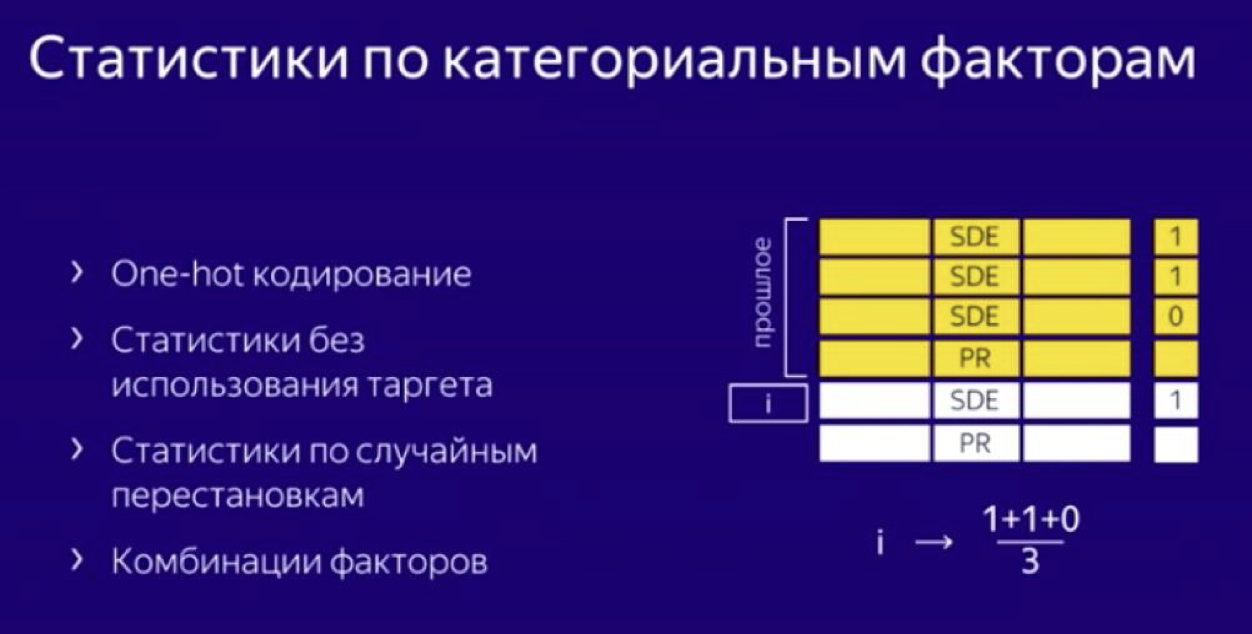

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.8 MB/s eta 0:00:00


## Загрузка данных

In [ ]:
from catboost.datasets import titanic
import numpy as np

train_df, test_df = titanic()

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Обработка данных

In [ ]:
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Заполним пропуски в данных некоторым уникальным значением (есть и другие техники, но здесь для простоты используем эту).

In [ ]:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

Разбиваем данные на матрицу объект-признак и вектор с целевой переменной.

In [ ]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

Посмотрим на типы признаков.

In [ ]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes != float)[0]

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Разобъем данные на трейн и валидацию.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df

## Обучение модели

In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [ ]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

В google colab нет возможности отрисовывать динамические графики (насколько мы знаем), поэтому для отрисовки графиков запускайте ноутбук на локальной машине.

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',
#    plot=True
)

Learning rate set to 0.028683
0:	learn: 0.6739988	test: 0.6742630	best: 0.6742630 (0)	total: 56.9ms	remaining: 56.8s
1:	learn: 0.6589013	test: 0.6592240	best: 0.6592240 (1)	total: 60.2ms	remaining: 30s
2:	learn: 0.6421502	test: 0.6426778	best: 0.6426778 (2)	total: 68.5ms	remaining: 22.8s
3:	learn: 0.6297276	test: 0.6302310	best: 0.6302310 (3)	total: 73.1ms	remaining: 18.2s
4:	learn: 0.6147184	test: 0.6198228	best: 0.6198228 (4)	total: 79ms	remaining: 15.7s
5:	learn: 0.6017730	test: 0.6073627	best: 0.6073627 (5)	total: 85ms	remaining: 14.1s
6:	learn: 0.5885309	test: 0.5956000	best: 0.5956000 (6)	total: 91.4ms	remaining: 13s
7:	learn: 0.5783200	test: 0.5858523	best: 0.5858523 (7)	total: 100ms	remaining: 12.4s
8:	learn: 0.5665895	test: 0.5743842	best: 0.5743842 (8)	total: 105ms	remaining: 11.6s
9:	learn: 0.5575381	test: 0.5662283	best: 0.5662283 (9)	total: 111ms	remaining: 11s
10:	learn: 0.5491045	test: 0.5575176	best: 0.5575176 (10)	total: 118ms	remaining: 10.6s
11:	learn: 0.5423887	test

## Кросс-валидация

In [ ]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params
#    plot=True
)

Посмотрим на среднее качество и его разброс по кросс-валидации

In [ ]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 355


## Применяем обученную модель

In [ ]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 1 0 1 0 1 0]
[[0.85473931 0.14526069]
 [0.76313031 0.23686969]
 [0.88972889 0.11027111]
 [0.87876173 0.12123827]
 [0.3611047  0.6388953 ]
 [0.90513381 0.09486619]
 [0.33434185 0.66565815]
 [0.78468564 0.21531436]
 [0.39429048 0.60570952]
 [0.94047549 0.05952451]]


## Улучшение предсказаний и другие возможности CatBoost

### Early Stopping

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds = 30,
    logging_level='Verbose',  # you can uncomment this for text output
#    plot=True
)

Learning rate set to 0.028683
0:	learn: 0.6739988	test: 0.6742630	best: 0.6742630 (0)	total: 7.57ms	remaining: 7.56s
1:	learn: 0.6589013	test: 0.6592240	best: 0.6592240 (1)	total: 10.8ms	remaining: 5.37s
2:	learn: 0.6421502	test: 0.6426778	best: 0.6426778 (2)	total: 18.3ms	remaining: 6.09s
3:	learn: 0.6297276	test: 0.6302310	best: 0.6302310 (3)	total: 24.2ms	remaining: 6.03s
4:	learn: 0.6147184	test: 0.6198228	best: 0.6198228 (4)	total: 30.7ms	remaining: 6.11s
5:	learn: 0.6017730	test: 0.6073627	best: 0.6073627 (5)	total: 37.3ms	remaining: 6.18s
6:	learn: 0.5885309	test: 0.5956000	best: 0.5956000 (6)	total: 47.9ms	remaining: 6.79s
7:	learn: 0.5783200	test: 0.5858523	best: 0.5858523 (7)	total: 64.7ms	remaining: 8.03s
8:	learn: 0.5665895	test: 0.5743842	best: 0.5743842 (8)	total: 72.5ms	remaining: 7.98s
9:	learn: 0.5575381	test: 0.5662283	best: 0.5662283 (9)	total: 78.7ms	remaining: 7.79s
10:	learn: 0.5491045	test: 0.5575176	best: 0.5575176 (10)	total: 85.5ms	remaining: 7.68s
11:	learn: 

In [ ]:
model.tree_count_

284

Получили непереобученную модель, причем не пришлось ждать 1000 итераций!

## Важность признаков

CatBoost поддерживает несколько способов вычисления важности признаков, в том числе широко применяемый сейчас подход Shap (про него поговорим в следующих модулях).

In [ ]:
feature_importances = model.get_feature_importance()

feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sex: 28.377591527551807
Pclass: 17.450379813673287
Parch: 10.276200044515498
Embarked: 8.761954037905873
Cabin: 8.281577549519369
SibSp: 7.950157281933983
Age: 7.842375602284014
Ticket: 5.620556803330715
Fare: 5.4392073392855105
PassengerId: 0.0
Name: 0.0


## Сохранение модели

In [ ]:
# сохраняем модель
model.save_model('catboost_model.dump')

# загружаем сохраненную модель
model.load_model('catboost_model.dump');